In [ ]:

"""
implemented FedProx, SGAN components (FeatureDrop, MBD),
Loss-based Client Selection, enhanced client-returned metrics, and server-side loss graphing.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import copy

# Hyperparameters
torch.manual_seed(0)
np.random.seed(0) # For client sampling consistency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 10
FAKE_CLASS_IDX = NUM_CLASSES # Real (0-9), Fake (10)
BATCH_SIZE = 32
Z_DIM = 100
LEARNING_RATE_D = 2e-5
LEARNING_RATE_G = 2e-6
LAMBDA_FM = 1.0 # Feature Matching loss weight
NUM_ROUNDS = 10
NUM_CLIENTS = 4 # Total number of clients available
CLIENTS_PER_ROUND_ACTUAL = 4 # Number of clients to actually select per round
LOCAL_EPOCHS = 2
NUM_LABELED = 100 # Number of labeled samples for the first client
SMOOTHING = 0.1 # Label smoothing
GRADIENT_CLIP_D = 1.0
GRADIENT_CLIP_G = 1.0
GENERATOR_UPDATES_PER_DISCRIMINATOR = 1
MU = 0.01 # FedProx proximal term coefficient

# PDF Component Hyperparameters
FEATURE_DROP_PROB = 0.5 # Probability for Feature Drop layer
MBD_OUT_FEATURES = 50  # Number of output features for MBD (dimensionality of the MBD tensor rows)


In [ ]:
# Client Definition
class Client:
    def __init__(self, client_id, dataset, is_labeled=False):
        self.client_id = client_id
        self.dataset = dataset
        self.is_labeled = is_labeled
        self.local_epochs_performed_last_round = 0 # For tracking

    def get_data_loader(self):
        return DataLoader(self.dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                          num_workers=2 if device.type == 'cuda' else 0,
                          pin_memory=True if device.type == 'cuda' else False)

    def has_labels(self):
        return self.is_labeled

    def __len__(self):
        return len(self.dataset)

In [ ]:
# Data Loading and Splitting
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Reduce dataset size for faster simulation
DATASET_SIZE_USED = 2000
actual_dataset_size = min(DATASET_SIZE_USED, len(full_dataset))
if DATASET_SIZE_USED > len(full_dataset):
    print(f"Warning: Requested dataset size {DATASET_SIZE_USED} is greater than available {len(full_dataset)}. Using {len(full_dataset)} samples.")

reduced_dataset, _ = random_split(full_dataset, [actual_dataset_size, len(full_dataset) - actual_dataset_size],
                                  generator=torch.Generator().manual_seed(42)) # Seed for reproducibility

# Split labeled and unlabeled subsets
actual_num_labeled = min(NUM_LABELED, len(reduced_dataset))
if NUM_LABELED > len(reduced_dataset):
    print(f"Warning: NUM_LABELED {NUM_LABELED} exceeds reduced dataset size {len(reduced_dataset)}. "
          f"Using {len(reduced_dataset)} for labeled set, no unlabeled data will be left.")
    labeled_subset = reduced_dataset
    unlabeled_subset_data = Subset(reduced_dataset, []) # Empty subset
else:
    labeled_subset, unlabeled_subset_data = random_split(
        reduced_dataset,
        [actual_num_labeled, len(reduced_dataset) - actual_num_labeled],
        generator=torch.Generator().manual_seed(42) # Seed for reproducibility
    )
unlabeled_subset_size = len(unlabeled_subset_data)

clients = []
# Client 0 is the labeled client
clients.append(Client(client_id=0, dataset=labeled_subset, is_labeled=True))

# Distribute unlabeled data among the remaining clients
num_unlabeled_clients_to_create = NUM_CLIENTS - 1
if num_unlabeled_clients_to_create > 0 and unlabeled_subset_size > 0:
    base_split_size = unlabeled_subset_size // num_unlabeled_clients_to_create
    remainder = unlabeled_subset_size % num_unlabeled_clients_to_create
    lengths = [base_split_size + 1 if i < remainder else base_split_size for i in range(num_unlabeled_clients_to_create)]
    lengths = [l for l in lengths if l > 0] # Filter out zero lengths

    if sum(lengths) > 0 and sum(lengths) <= unlabeled_subset_size : # Ensure lengths match available data
        actual_unlabeled_subsets = random_split(unlabeled_subset_data, lengths, generator=torch.Generator().manual_seed(43))
        for i, subset in enumerate(actual_unlabeled_subsets):
            if len(clients) < NUM_CLIENTS:
                 clients.append(Client(client_id=len(clients), dataset=subset, is_labeled=False))
    else:
        print("Warning: Not enough unlabeled data to distribute among remaining clients as requested, or issue with split lengths.")
elif num_unlabeled_clients_to_create > 0 and unlabeled_subset_size == 0:
    print("Warning: No unlabeled data left to distribute among other clients.")

# Fill remaining client slots with empty datasets if NUM_CLIENTS is not met
while len(clients) < NUM_CLIENTS:
    print(f"Warning: Creating client {len(clients)} with empty dataset as not enough data was available for splitting.")
    clients.append(Client(client_id=len(clients), dataset=Subset(full_dataset, []), is_labeled=False))


print("Client Setup:")
for c in clients:
    loader_batches = 0
    if len(c.dataset) > 0:
        loader_batches = len(c.get_data_loader()) # Call get_data_loader to see batch count
    print(f"Client {c.client_id} | Labeled={c.has_labels()} | Samples={len(c)} | Batches (drop_last=True)={loader_batches}")
print("-" * 30)

Client Setup:
Client 0 | Labeled=True | Samples=100 | Batches (drop_last=True)=3
Client 1 | Labeled=False | Samples=634 | Batches (drop_last=True)=19
Client 2 | Labeled=False | Samples=633 | Batches (drop_last=True)=19
Client 3 | Labeled=False | Samples=633 | Batches (drop_last=True)=19
------------------------------


In [ ]:
#  Model Definition

class MiniBatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims=5): # kernel_dims is part of MBD_OUT_FEATURES
        super(MiniBatchDiscrimination, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims
        self.T = nn.Linear(in_features, out_features * kernel_dims, bias=False)

    def forward(self, x):
        # x is (batch_size, in_features)
        # M_i = T(h_i) -> (batch_size, out_features * kernel_dims)
        projected_x = self.T(x)
        # Reshape to (batch_size, out_features, kernel_dims)
        reshaped_x = projected_x.view(-1, self.out_features, self.kernel_dims)


        diffs = torch.abs(reshaped_x.unsqueeze(1) - reshaped_x.unsqueeze(0))
        l1_dist = diffs.sum(dim=3) # (batch_size, batch_size, out_features)

        mbd_feats_b = torch.exp(-l1_dist).sum(dim=1) - torch.exp(torch.zeros(1, device=x.device)) # (batch_size, out_features)

        return torch.cat([x, mbd_feats_b], dim=1)


class SemiSupervisedDiscriminator(nn.Module):
    def __init__(self, input_dim=3*32*32, num_classes=NUM_CLASSES,
                 fc_out_features_before_mbd=256,
                 feature_drop_prob=FEATURE_DROP_PROB,
                 mbd_out_features=MBD_OUT_FEATURES,
                 mbd_kernel_dims=50):
        super(SemiSupervisedDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.fc_out_features_before_mbd = fc_out_features_before_mbd

        self.feature_extractor_fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, fc_out_features_before_mbd),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Feature Drop Layer
        self.feature_drop = nn.Dropout(feature_drop_prob)

        self.mbd_layer = MiniBatchDiscrimination(fc_out_features_before_mbd, mbd_out_features, mbd_kernel_dims)

        # Input to final layer: fc_out_features_before_mbd (original) + mbd_out_features (from MBD)
        final_input_dim = fc_out_features_before_mbd + mbd_out_features
        self.final_classification_layer = nn.Linear(final_input_dim, num_classes + 1)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        features_extracted = self.feature_extractor_fc(x_flat)

        features_dropped = self.feature_drop(features_extracted)

        features_augmented_mbd = self.mbd_layer(features_dropped)

        logits = self.final_classification_layer(features_augmented_mbd)
        return logits

    def extract_features(self, x): # For feature matching (before feature drop & MBD)
        x_flat = x.view(x.size(0), -1)
        feats = self.feature_extractor_fc(x_flat)
        return feats

class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, output_dim=3*32*32):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img_flat = self.fc(z)
        return img_flat.view(-1, 3, 32, 32)

# Loss Functions
def supervised_loss(logits, labels, smoothing=SMOOTHING):
    class_logits = logits[:, :NUM_CLASSES] # First NUM_CLASSES logits are for classification
    log_probs = F.log_softmax(class_logits, dim=1)
    true_dist = torch.zeros_like(log_probs).scatter_(1, labels.unsqueeze(1), 1.0)
    if smoothing > 0:
        true_dist = true_dist * (1 - smoothing) + smoothing / NUM_CLASSES
    return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

    # Real loss
def unsupervised_loss_real(logits): # D wants to output "not fake" for real images
    # Probability that the sample is fake (logit at FAKE_CLASS_IDX)
    # We want log(1 - P(fake|real_data)) to be maximized, or -log(1 - P(fake|real_data)) to be minimized
    prob_fake_for_real = F.softmax(logits, dim=1)[:, FAKE_CLASS_IDX]
    loss = -torch.log(1.0 - prob_fake_for_real + 1e-8).mean()
    return loss

    # Fake loss
def unsupervised_loss_fake(logits): # D wants to output "fake" for fake images
    # We want log(P(fake|fake_data)) to be maximized, or -log(P(fake|fake_data)) to be minimized
    prob_fake_for_fake = F.softmax(logits, dim=1)[:, FAKE_CLASS_IDX]
    loss = -torch.log(prob_fake_for_fake + 1e-8).mean()
    return loss

def generator_loss_adversarial(logits_fake): # G wants D to output "not fake" for fake images
    # G wants to maximize log(1 - P(fake|fake_data_from_G))
    prob_fake_for_fake_from_G = F.softmax(logits_fake, dim=1)[:, FAKE_CLASS_IDX]
    loss = -torch.log(1.0 - prob_fake_for_fake_from_G + 1e-8).mean()
    return loss

def feature_matching_loss(real_features_mean, fake_features_mean):
    return F.mse_loss(fake_features_mean, real_features_mean)



In [ ]:
# FedProx Client Training Function
def train_on_client_data_fedprox(client, initial_global_gen_state_dict, initial_global_disc_state_dict,
                                 mu, local_epochs, local_lr_g, local_lr_d, lambda_fm):
    if len(client.dataset) == 0 or len(client.get_data_loader()) == 0:
        metrics = {
            "client_id": client.client_id, "is_labeled": client.has_labels(),
            "avg_loss_D": float('nan'), "avg_loss_G": float('nan'),
            "samples_processed": 0, "epochs_performed": 0,
            "client_specific_lr_g": local_lr_g, "client_specific_lr_d": local_lr_d,
            "client_batch_size": BATCH_SIZE
        }

        return copy.deepcopy(initial_global_gen_state_dict), copy.deepcopy(initial_global_disc_state_dict), metrics

    local_generator = Generator(z_dim=Z_DIM).to(device)
    local_discriminator = SemiSupervisedDiscriminator(
        fc_out_features_before_mbd=256,
        feature_drop_prob=FEATURE_DROP_PROB,
        mbd_out_features=MBD_OUT_FEATURES,
        mbd_kernel_dims=50
    ).to(device)

    local_generator.load_state_dict(copy.deepcopy(initial_global_gen_state_dict))
    local_discriminator.load_state_dict(copy.deepcopy(initial_global_disc_state_dict))

    # Store initial global parameters for FedProx proximal term
    initial_gen_params_for_prox = [p.clone().detach() for p in local_generator.parameters()]
    initial_disc_params_for_prox = [p.clone().detach() for p in local_discriminator.parameters()]

    local_optim_D = optim.Adam(local_discriminator.parameters(), lr=local_lr_d, betas=(0.5, 0.999))
    local_optim_G = optim.Adam(local_generator.parameters(), lr=local_lr_g, betas=(0.5, 0.999))

    loader = client.get_data_loader()
    is_labeled = client.has_labels()
    total_loss_D_base, total_loss_G_base, batch_count = 0.0, 0.0, 0
    samples_processed_client = 0

    local_generator.train()
    local_discriminator.train()

    for epoch in range(local_epochs):
        for real_images, labels_or_ignore in loader:
            if len(real_images) < BATCH_SIZE and loader.drop_last == False:
                 continue # Skip incomplete batches if drop_last was False for some reason

            batch_count += 1
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)
            if current_batch_size == 0: continue # Should not happen with drop_last=True
            samples_processed_client += current_batch_size

            # Discriminator Update
            local_optim_D.zero_grad()
            base_loss_D_batch = 0.0

            # Loss for real images
            logits_real = local_discriminator(real_images)
            base_loss_D_batch += unsupervised_loss_real(logits_real)
            if is_labeled:
                labels = labels_or_ignore.to(device)
                base_loss_D_batch += supervised_loss(logits_real, labels, smoothing=SMOOTHING)

            # For Feature Matching (mean of features from real data before MBD and dropout)
            with torch.no_grad():
                real_feat_mean_detached = local_discriminator.extract_features(real_images).mean(dim=0).detach()

            # Loss for fake images
            noise = torch.randn(current_batch_size, Z_DIM, device=device)
            with torch.no_grad():
                fake_images = local_generator(noise).detach()
            logits_fake = local_discriminator(fake_images)
            base_loss_D_batch += unsupervised_loss_fake(logits_fake)

            # FedProx term for Discriminator
            prox_term_D = 0.0
            for local_param_d, initial_global_param_d in zip(local_discriminator.parameters(), initial_disc_params_for_prox):
                if local_param_d.requires_grad:
                     prox_term_D += torch.sum((local_param_d - initial_global_param_d.to(device))**2)
            loss_D_total = base_loss_D_batch + (MU / 2) * prox_term_D

            if torch.isnan(loss_D_total) or torch.isinf(loss_D_total):
                print(f"Warning: Invalid loss_D ({loss_D_total.item()}) on Client {client.client_id}. Skipping D update.")
            else:
                loss_D_total.backward()
                torch.nn.utils.clip_grad_norm_(local_discriminator.parameters(), max_norm=GRADIENT_CLIP_D)
                local_optim_D.step()
            total_loss_D_base += base_loss_D_batch.item()


            # Generator Update (potentially multiple times per D update)
            current_total_loss_G_batch_base = 0.0
            nan_in_g_update_step = False
            for _ in range(GENERATOR_UPDATES_PER_DISCRIMINATOR):
                 local_optim_G.zero_grad()
                 noise_g = torch.randn(current_batch_size, Z_DIM, device=device) # Use current_batch_size
                 fake_images_g = local_generator(noise_g)

                 logits_fake_for_G = local_discriminator(fake_images_g)
                 loss_G_adv = generator_loss_adversarial(logits_fake_for_G)

                 # Feature matching loss for G
                 fake_feat_mean_for_G = local_discriminator.extract_features(fake_images_g).mean(dim=0)
                 loss_G_fm_val = feature_matching_loss(real_feat_mean_detached, fake_feat_mean_for_G)
                 base_loss_G_batch_step = loss_G_adv + LAMBDA_FM * loss_G_fm_val

                 # FedProx term for Generator
                 prox_term_G = 0.0
                 for local_param_g, initial_global_param_g in zip(local_generator.parameters(), initial_gen_params_for_prox):
                      if local_param_g.requires_grad:
                          prox_term_G += torch.sum((local_param_g - initial_global_param_g.to(device))**2)
                 loss_G_total_step = base_loss_G_batch_step + (MU / 2) * prox_term_G

                 if torch.isnan(loss_G_total_step) or torch.isinf(loss_G_total_step):
                     print(f"Warning: Invalid loss_G ({loss_G_total_step.item()}) on Client {client.client_id}. Skipping this G update step.")
                     nan_in_g_update_step = True; break
                 else:
                    loss_G_total_step.backward()
                    torch.nn.utils.clip_grad_norm_(local_generator.parameters(), max_norm=GRADIENT_CLIP_G)
                    local_optim_G.step()
                    current_total_loss_G_batch_base += base_loss_G_batch_step.item()

            if not nan_in_g_update_step:
                total_loss_G_base += current_total_loss_G_batch_base / GENERATOR_UPDATES_PER_DISCRIMINATOR
            else:
                total_loss_G_base = float('nan')

    client.local_epochs_performed_last_round = local_epochs

    avg_loss_D_base_client = total_loss_D_base / batch_count if batch_count > 0 and not np.isnan(total_loss_D_base) else float('nan')
    avg_loss_G_base_client = total_loss_G_base / batch_count if batch_count > 0 and not np.isnan(total_loss_G_base) else float('nan')

    metrics = {
        "client_id": client.client_id,
        "is_labeled": is_labeled,
        "avg_loss_D": avg_loss_D_base_client,
        "avg_loss_G": avg_loss_G_base_client,
        "samples_processed": samples_processed_client,
        "epochs_performed": local_epochs,
        "client_specific_lr_g": local_lr_g,
        "client_specific_lr_d": local_lr_d,
        "client_batch_size": BATCH_SIZE
    }
    return local_generator.state_dict(), local_discriminator.state_dict(), metrics



Starting Federated Training with FedProx (μ=0.01), FeatureDrop (0.5), MBD (out_B=50, kernel_C=50)...

=== Federated Round 1/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=4.1235, Avg Base LossG=0.2220, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=1.2145, Avg Base LossG=0.5019, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=1.2105, Avg Base LossG=0.5005, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=1.2133, Avg Base LossG=0.4971, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 1 Average Base Losses (among successfully trained selected clients): D=1.9405, G=0.4304


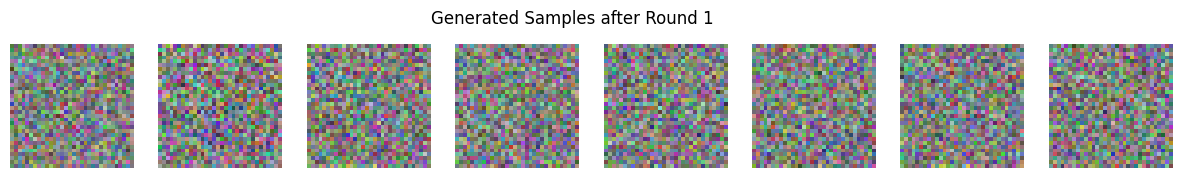


=== Federated Round 2/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.9301, Avg Base LossG=0.9730, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.4065, Avg Base LossG=1.5756, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.3989, Avg Base LossG=1.5713, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.4053, Avg Base LossG=1.5962, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 2 Average Base Losses (among successfully trained selected clients): D=1.0352, G=1.4290


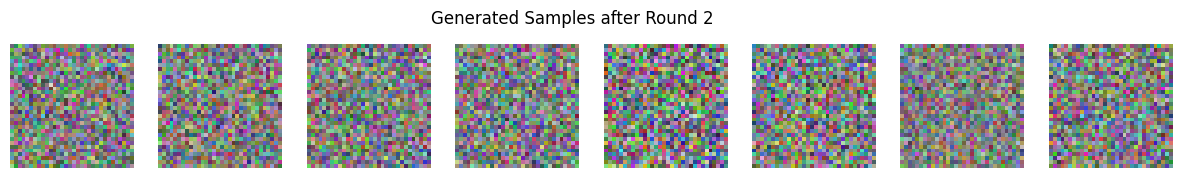


=== Federated Round 3/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.5186, Avg Base LossG=2.3474, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.1498, Avg Base LossG=3.1127, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.1493, Avg Base LossG=3.0905, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.1461, Avg Base LossG=3.0973, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 3 Average Base Losses (among successfully trained selected clients): D=0.7410, G=2.9120


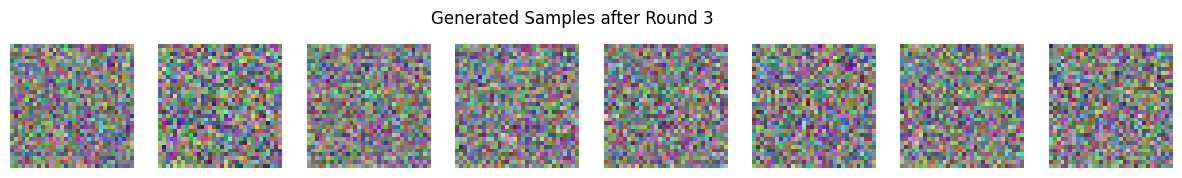


=== Federated Round 4/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.4062, Avg Base LossG=3.9825, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0699, Avg Base LossG=4.6977, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0681, Avg Base LossG=4.7503, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0668, Avg Base LossG=4.7364, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 4 Average Base Losses (among successfully trained selected clients): D=0.6528, G=4.5417


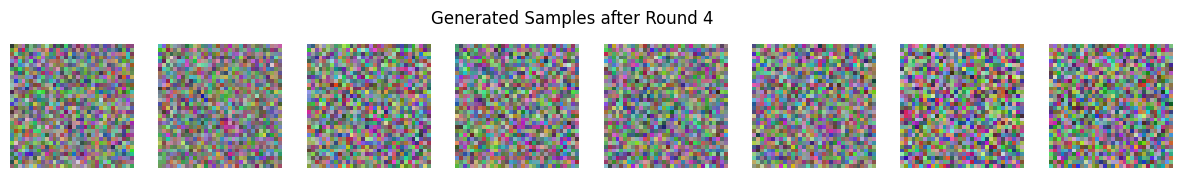


=== Federated Round 5/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.3954, Avg Base LossG=5.5945, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0368, Avg Base LossG=6.1908, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0360, Avg Base LossG=6.1743, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0338, Avg Base LossG=6.1691, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 5 Average Base Losses (among successfully trained selected clients): D=0.6255, G=6.0322


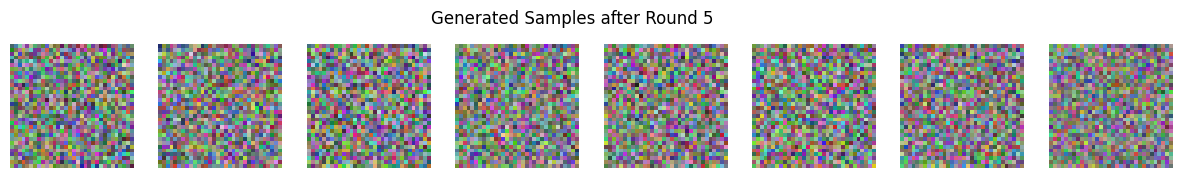


=== Federated Round 6/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.4113, Avg Base LossG=6.8147, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0219, Avg Base LossG=7.3427, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0213, Avg Base LossG=7.3484, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0189, Avg Base LossG=7.3675, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 6 Average Base Losses (among successfully trained selected clients): D=0.6184, G=7.2183


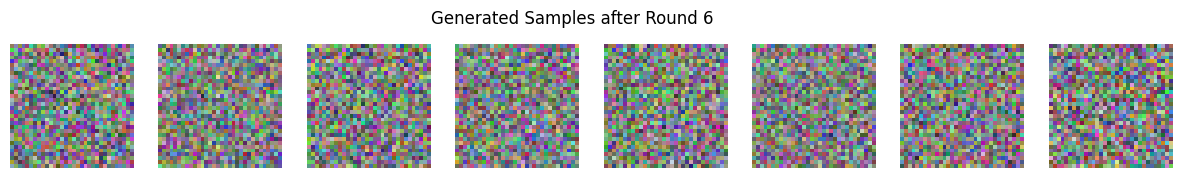


=== Federated Round 7/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.4568, Avg Base LossG=7.9055, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0133, Avg Base LossG=8.4178, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0129, Avg Base LossG=8.4023, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0112, Avg Base LossG=8.4421, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 7 Average Base Losses (among successfully trained selected clients): D=0.6235, G=8.2919


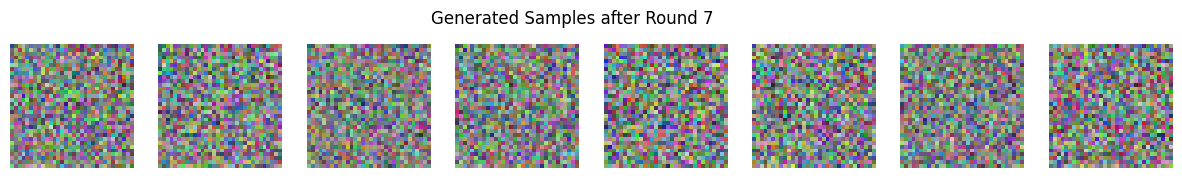


=== Federated Round 8/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.4998, Avg Base LossG=8.8524, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0083, Avg Base LossG=9.3641, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0082, Avg Base LossG=9.3573, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0065, Avg Base LossG=9.3961, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 8 Average Base Losses (among successfully trained selected clients): D=0.6307, G=9.2425


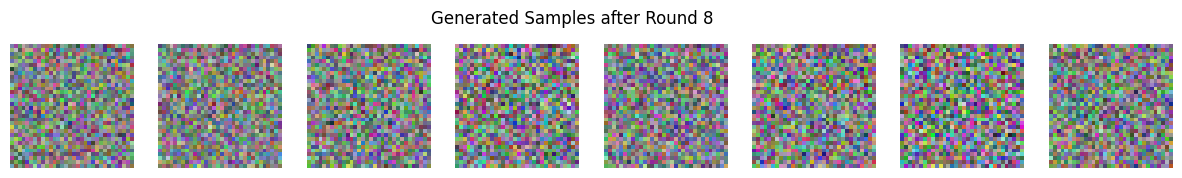


=== Federated Round 9/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.5291, Avg Base LossG=9.7023, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0053, Avg Base LossG=10.1535, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0056, Avg Base LossG=10.0949, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0041, Avg Base LossG=10.1521, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 9 Average Base Losses (among successfully trained selected clients): D=0.6360, G=10.0257


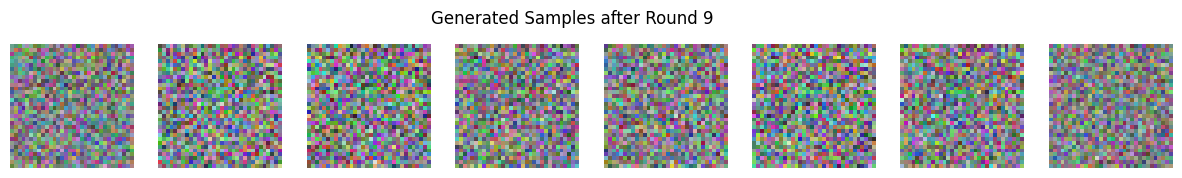


=== Federated Round 10/10 ===
  Selected all 4 clients with data.
  Training Client 0 (Labeled: True, Samples: 100)...
    Client 0 finished training. Avg Base LossD=2.6021, Avg Base LossG=10.3386, Samples=192, Epochs=2
  Training Client 1 (Labeled: False, Samples: 634)...
    Client 1 finished training. Avg Base LossD=0.0036, Avg Base LossG=10.7229, Samples=1216, Epochs=2
  Training Client 2 (Labeled: False, Samples: 633)...
    Client 2 finished training. Avg Base LossD=0.0037, Avg Base LossG=10.7254, Samples=1216, Epochs=2
  Training Client 3 (Labeled: False, Samples: 633)...
    Client 3 finished training. Avg Base LossD=0.0026, Avg Base LossG=10.7749, Samples=1216, Epochs=2
  Aggregating client updates...
  Aggregation complete based on 4 valid clients.
  Round 10 Average Base Losses (among successfully trained selected clients): D=0.6530, G=10.6404


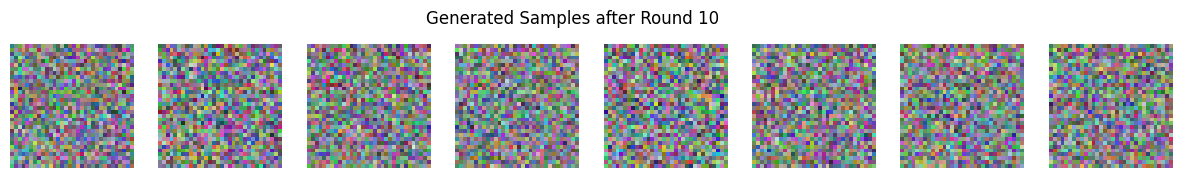


Plotting server-side average losses per round...


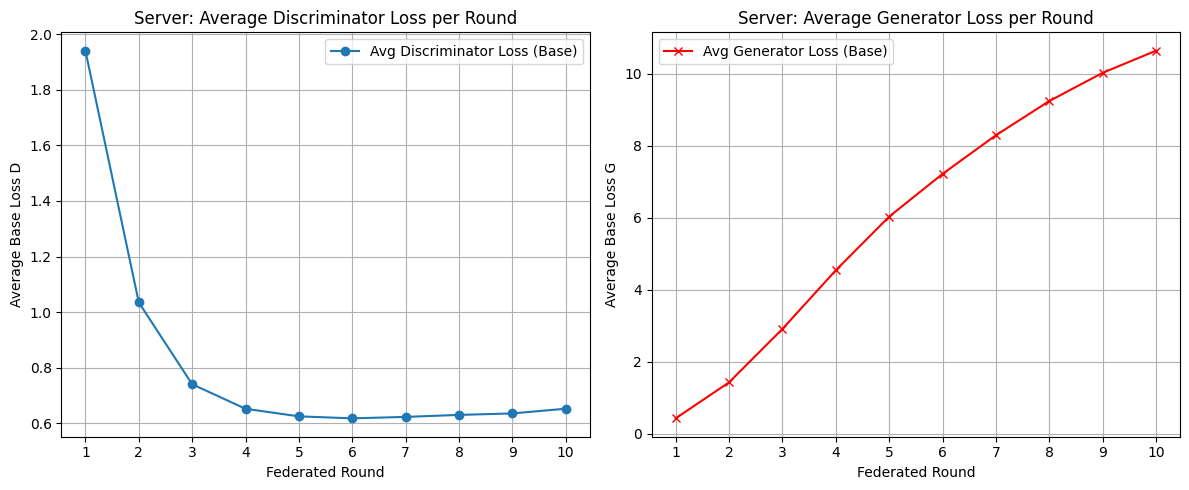


Federated Training with FedProx, SGAN components, Loss-based Client Selection, and Graphing complete.


In [ ]:
# Server Initialization
generator = Generator(z_dim=Z_DIM).to(device)
discriminator = SemiSupervisedDiscriminator(
    fc_out_features_before_mbd=256,
    feature_drop_prob=FEATURE_DROP_PROB,
    mbd_out_features=MBD_OUT_FEATURES,
    mbd_kernel_dims=50
).to(device)

global_generator_state = generator.state_dict()
global_discriminator_state = discriminator.state_dict()

# For loss-based client selection & graphing
client_loss_history = {client_obj.client_id: float('inf') for client_obj in clients}
all_server_avg_D_losses = []
all_server_avg_G_losses = []

print(f"\nStarting Federated Training with FedProx (μ={MU}), FeatureDrop ({FEATURE_DROP_PROB}), MBD (out_B={MBD_OUT_FEATURES}, kernel_C=50)...")

# --- Federated Learning Loop ---
for round_idx in range(NUM_ROUNDS):
    print(f"\n=== Federated Round {round_idx+1}/{NUM_ROUNDS} ===")

    client_G_states_for_agg = []
    client_D_states_for_agg = []
    client_sample_counts_for_agg = []
    round_metrics_all_selected_clients = [] # Stores metrics for all *selected* clients this round

    # --- Client Selection
    selected_clients_this_round = []
    clients_with_data = [c for c in clients if len(c.dataset) > 0 and len(c.get_data_loader()) > 0]

    if not clients_with_data:
        print("  No clients with data (or enough data for a full batch with drop_last=True) to train. Ending training.")
        break

    num_selectable_clients = len(clients_with_data)

    if CLIENTS_PER_ROUND_ACTUAL >= num_selectable_clients or CLIENTS_PER_ROUND_ACTUAL <= 0:
        selected_clients_this_round = clients_with_data
        print(f"  Selected all {len(selected_clients_this_round)} clients with data.")
    else:
        print(f"  Selecting {CLIENTS_PER_ROUND_ACTUAL} clients using loss-based strategy...")
        # Separate labeled (client 0) and unlabeled clients that have data
        labeled_client = next((c for c in clients_with_data if c.client_id == 0), None)
        unlabeled_clients_with_data = [c for c in clients_with_data if c.client_id != 0]

        # trying to include the labeled client if it has data and we are selecting
        if labeled_client and len(selected_clients_this_round) < CLIENTS_PER_ROUND_ACTUAL:
            selected_clients_this_round.append(labeled_client)
            print(f"    Prioritized labeled client: {labeled_client.client_id}")

        remaining_slots = CLIENTS_PER_ROUND_ACTUAL - len(selected_clients_this_round)

        # Selecting from unlabeled clients if slots remain
        if remaining_slots > 0 and unlabeled_clients_with_data:
            # Filter out clients already selected (e.g. if labeled client was added)
            unlabeled_candidates = [c for c in unlabeled_clients_with_data if c not in selected_clients_this_round]

            if unlabeled_candidates:
                default_high_loss = float('inf')
                # Clients with no/NaN history get default_high_loss, effectively random among them if all are like that.
                sorted_unlabeled_candidates = sorted(
                    unlabeled_candidates,
                    key=lambda c: client_loss_history.get(c.client_id, default_high_loss) if not np.isnan(client_loss_history.get(c.client_id, default_high_loss)) else default_high_loss,
                    reverse=True
                )

                # If all candidates have default_high_loss (e.g., first round of selection), shuffle for randomness
                is_first_selection_round_or_no_history = all(
                    (client_loss_history.get(c.client_id, default_high_loss) == default_high_loss or
                     np.isnan(client_loss_history.get(c.client_id, default_high_loss)))
                    for c in sorted_unlabeled_candidates
                )
                if is_first_selection_round_or_no_history and len(sorted_unlabeled_candidates) > 1:
                    np.random.shuffle(sorted_unlabeled_candidates)
                    print("    Selecting unlabeled clients randomly (no valid/differentiating loss history).")

                num_to_select_from_unlabeled = min(remaining_slots, len(sorted_unlabeled_candidates))
                selected_unlabeled_from_sorted = sorted_unlabeled_candidates[:num_to_select_from_unlabeled]
                selected_clients_this_round.extend(selected_unlabeled_from_sorted)
                print(f"    Selected {len(selected_unlabeled_from_sorted)} unlabeled clients: {[c.client_id for c in selected_unlabeled_from_sorted]}")

        # If still haven't filled CLIENTS_PER_ROUND_ACTUAL (e.g., few unlabeled, or CLIENTS_PER_ROUND_ACTUAL is high)
        # filling randomly from any remaining clients_with_data not yet selected
        if len(selected_clients_this_round) < CLIENTS_PER_ROUND_ACTUAL:
            remaining_to_choose_from_any = [c for c in clients_with_data if c not in selected_clients_this_round]
            if remaining_to_choose_from_any:
                num_to_randomly_add = min(CLIENTS_PER_ROUND_ACTUAL - len(selected_clients_this_round), len(remaining_to_choose_from_any))
                randomly_added = np.random.choice(remaining_to_choose_from_any, size=num_to_randomly_add, replace=False).tolist()
                selected_clients_this_round.extend(randomly_added)
                print(f"    Additionally selected {len(randomly_added)} clients randomly to fill slots: {[c.client_id for c in randomly_added]}")

        print(f"  Final selected clients for this round ({len(selected_clients_this_round)}): {[c.client_id for c in selected_clients_this_round]}")


    if not selected_clients_this_round:
        print("  No clients selected for training this round (after selection logic). Ending training.")
        break

    current_round_global_gen_state = copy.deepcopy(global_generator_state)
    current_round_global_disc_state = copy.deepcopy(global_discriminator_state)

    for c_train in selected_clients_this_round:
        print(f"  Training Client {c_train.client_id} (Labeled: {c_train.has_labels()}, Samples: {len(c_train.dataset)})...")

        updated_local_gen_state, updated_local_disc_state, metrics = train_on_client_data_fedprox(
            client=c_train,
            initial_global_gen_state_dict=current_round_global_gen_state,
            initial_global_disc_state_dict=current_round_global_disc_state,
            mu=MU, local_epochs=LOCAL_EPOCHS,
            local_lr_g=LEARNING_RATE_G, local_lr_d=LEARNING_RATE_D,
            lambda_fm=LAMBDA_FM
        )
        round_metrics_all_selected_clients.append(metrics) # Store metrics for every selected client

        # Update loss history for selection in the *next* round
        if metrics["samples_processed"] > 0 and not (np.isnan(metrics['avg_loss_D']) or np.isinf(metrics['avg_loss_D'])):
            client_loss_history[metrics['client_id']] = metrics['avg_loss_D']
        elif metrics["samples_processed"] == 0 :
             client_loss_history[metrics['client_id']] = float('inf')


        # For aggregation, consider only successfully trained clients with valid losses for G and D
        if metrics["samples_processed"] > 0 and \
           not (np.isnan(metrics['avg_loss_G']) or np.isinf(metrics['avg_loss_G'])) and \
           not (np.isnan(metrics['avg_loss_D']) or np.isinf(metrics['avg_loss_D'])):
            print(f"    Client {metrics['client_id']} finished training. Avg Base LossD={metrics['avg_loss_D']:.4f}, Avg Base LossG={metrics['avg_loss_G']:.4f}, Samples={metrics['samples_processed']}, Epochs={metrics['epochs_performed']}")
            client_G_states_for_agg.append(updated_local_gen_state)
            client_D_states_for_agg.append(updated_local_disc_state)
            client_sample_counts_for_agg.append(metrics['samples_processed'])
        else:
            print(f"    Client {metrics['client_id']} had no data, resulted in invalid loss, or did not complete training meaningfully. Skipping its update for aggregation.")

    # Server Aggregation Phase (FedAvg/FedProx style)
    print("  Aggregating client updates...")
    total_samples_for_agg = sum(client_sample_counts_for_agg)

    if total_samples_for_agg > 0 and client_G_states_for_agg:
        avg_G_state = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in global_generator_state.items()}
        avg_D_state = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in global_discriminator_state.items()}

        for i in range(len(client_G_states_for_agg)): # Iterate through the collected valid updates
            weight = client_sample_counts_for_agg[i] / total_samples_for_agg

            # Aggregate Generator
            for k_g in avg_G_state.keys():
                avg_G_state[k_g] += (client_G_states_for_agg[i][k_g] * weight).to(avg_G_state[k_g].dtype)

            # Aggregate Discriminator
            for k_d in avg_D_state.keys():
                avg_D_state[k_d] += (client_D_states_for_agg[i][k_d] * weight).to(avg_D_state[k_d].dtype)

        global_generator_state = avg_G_state
        global_discriminator_state = avg_D_state
        print(f"  Aggregation complete based on {len(client_G_states_for_agg)} valid clients.")
    else:
        print("  No valid client updates this round or no samples processed by valid clients. Global model unchanged.")

    generator.load_state_dict(global_generator_state)
    discriminator.load_state_dict(global_discriminator_state)

    #  Evaluation / Sample Generation for this Round

    valid_metrics_d_this_round = [m['avg_loss_D'] for m in round_metrics_all_selected_clients if m['samples_processed'] > 0 and not np.isnan(m['avg_loss_D'])]
    valid_metrics_g_this_round = [m['avg_loss_G'] for m in round_metrics_all_selected_clients if m['samples_processed'] > 0 and not np.isnan(m['avg_loss_G'])]

    avg_round_loss_D_server = np.mean(valid_metrics_d_this_round) if valid_metrics_d_this_round else float('nan')
    avg_round_loss_G_server = np.mean(valid_metrics_g_this_round) if valid_metrics_g_this_round else float('nan')

    all_server_avg_D_losses.append(avg_round_loss_D_server)
    all_server_avg_G_losses.append(avg_round_loss_G_server)
    print(f"  Round {round_idx+1} Average Base Losses (among successfully trained selected clients): D={avg_round_loss_D_server:.4f}, G={avg_round_loss_G_server:.4f}")


    generator.eval()
    if Z_DIM > 0:
        fixed_noise_eval = torch.randn(8, Z_DIM, device=device)
        with torch.no_grad():
            samples = generator(fixed_noise_eval).cpu()
        samples = (samples + 1) / 2
        samples = torch.clamp(samples, 0, 1)

        fig, axes = plt.subplots(1, 8, figsize=(15,2))
        for i in range(8):
            img_display = samples[i].permute(1, 2, 0).numpy()
            axes[i].imshow(img_display)
            axes[i].axis('off')
        plt.suptitle(f"Generated Samples after Round {round_idx+1}")
        plt.show()
    else:
        print("  Z_DIM is 0 or negative, skipping sample generation.")
    generator.train()

#  Plotting server-side average losses after all rounds
print("\nPlotting server-side average losses per round...")
num_actual_rounds = len(all_server_avg_D_losses)
rounds_for_plot = range(1, num_actual_rounds + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

valid_d_losses_plot = [(r, l) for r, l in zip(rounds_for_plot, all_server_avg_D_losses) if not np.isnan(l)]
if valid_d_losses_plot:
    r_d, l_d = zip(*valid_d_losses_plot)
    plt.plot(r_d, l_d, marker='o', linestyle='-', label='Avg Discriminator Loss (Base)')
else:
    plt.text(0.5, 0.5, 'No valid D loss data to plot', horizontalalignment='center', verticalalignment='center')
plt.title('Server: Average Discriminator Loss per Round')
plt.xlabel('Federated Round')
plt.ylabel('Average Base Loss D')
if num_actual_rounds > 0: plt.xticks(rounds_for_plot)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
valid_g_losses_plot = [(r, l) for r, l in zip(rounds_for_plot, all_server_avg_G_losses) if not np.isnan(l)]
if valid_g_losses_plot:
    r_g, l_g = zip(*valid_g_losses_plot)
    plt.plot(r_g, l_g, marker='x', linestyle='-', color='r', label='Avg Generator Loss (Base)')
else:
    plt.text(0.5, 0.5, 'No valid G loss data to plot', horizontalalignment='center', verticalalignment='center')

plt.title('Server: Average Generator Loss per Round')
plt.xlabel('Federated Round')
plt.ylabel('Average Base Loss G')
if num_actual_rounds > 0: plt.xticks(rounds_for_plot)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFederated Training with FedProx, SGAN components, Loss-based Client Selection, and Graphing complete.")
